In [1]:
import pandas as pd
import numpy as np

In [2]:
# Download UFC fight data from Kaggle
import opendatasets as od
#username: bryantndongmo
#key: d447ca91c20fd123b49f35fe29a0689d
od.download(
    "https://www.kaggle.com/datasets/remypereira/mma-dataset-2023-ufc")

Skipping, found downloaded files in ".\mma-dataset-2023-ufc" (use force=True to force download)


In [3]:
# Load downloaded datasets with Pandas
fight_data = pd.read_csv('mma-dataset-2023-ufc/ufc_fight_data.csv')
fighter_data = pd.read_csv('mma-dataset-2023-ufc/ufc_fighter_data.csv')
fight_stat_data = pd.read_csv('mma-dataset-2023-ufc/ufc_fight_stat_data.csv')
event_data = pd.read_csv('mma-dataset-2023-ufc/ufc_event_data.csv')

In [4]:
fight_to_event = dict(zip(fight_data['fight_id'], fight_data['event_id']))
event_to_date = dict(zip(event_data['event_id'], event_data['event_date']))

In [5]:
# Early fights don't have control time data so will exclude
fight_stat_data = fight_stat_data[fight_stat_data.fight_id >= 2505]

array([[<Axes: title={'center': 'knockdowns'}>,
        <Axes: title={'center': 'total_strikes_att'}>,
        <Axes: title={'center': 'total_strikes_succ'}>],
       [<Axes: title={'center': 'sig_strikes_att'}>,
        <Axes: title={'center': 'sig_strikes_succ'}>,
        <Axes: title={'center': 'takedown_att'}>],
       [<Axes: title={'center': 'takedown_succ'}>,
        <Axes: title={'center': 'submission_att'}>,
        <Axes: title={'center': 'reversals'}>]], dtype=object)

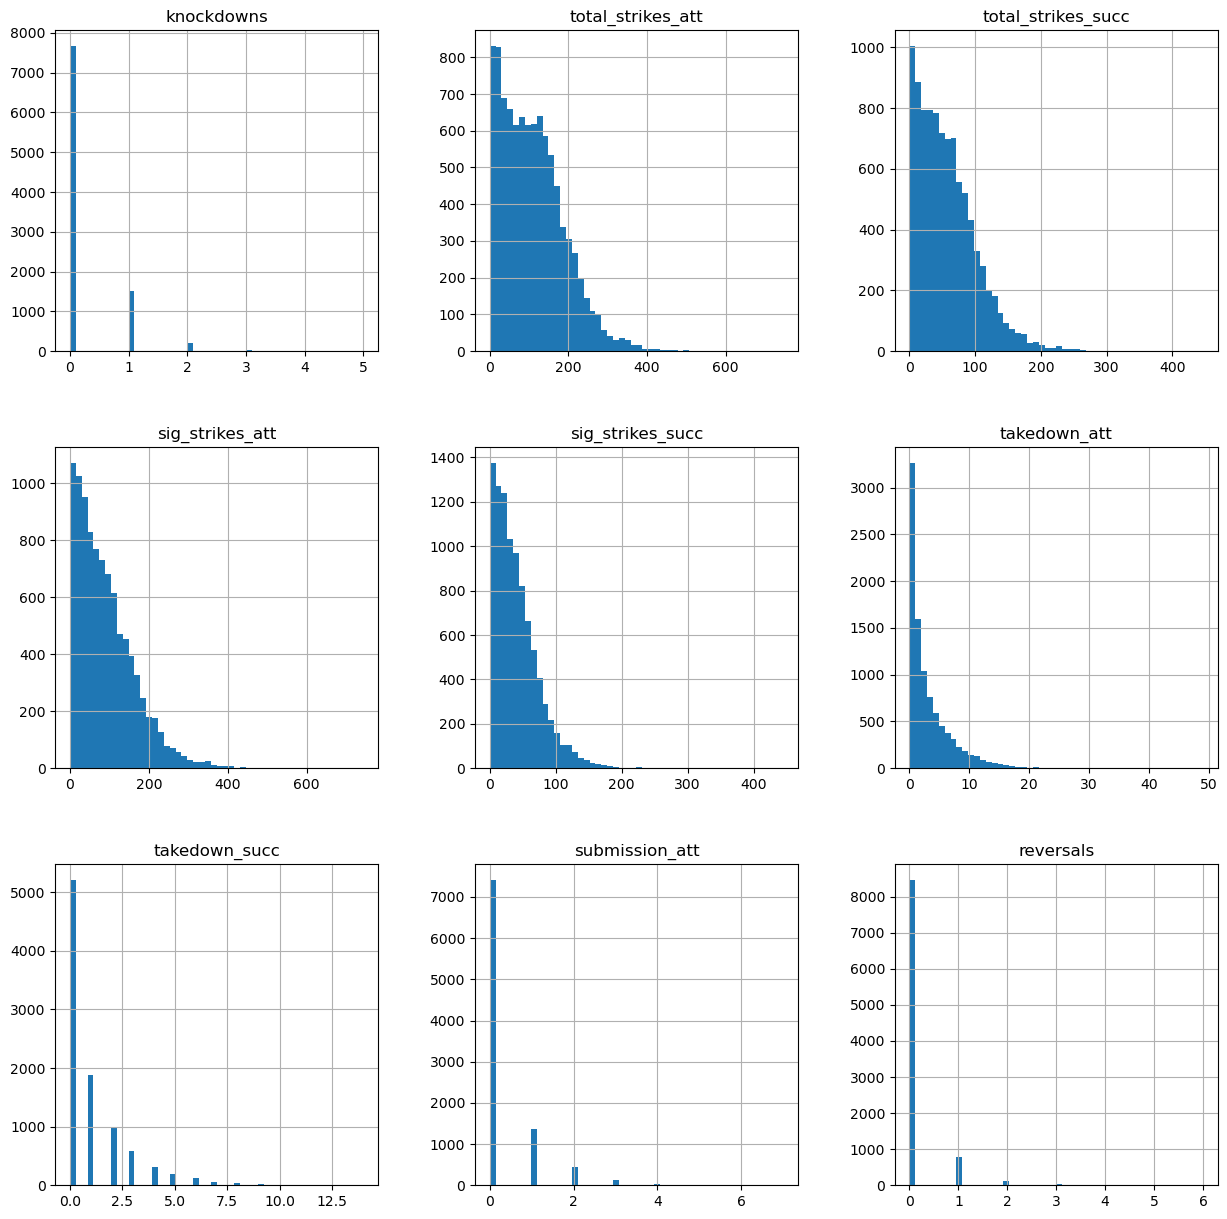

In [6]:
#Visualize fight stat distributions
fight_stat_data[fight_stat_data.columns[3:]].hist(bins=50, figsize=(15,15))

# Feature Engineering

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Columns to impute
columns_to_impute = ['fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm']

# Impute missing values using mean
imputer = IterativeImputer()
fighter_data[columns_to_impute] = imputer.fit_transform(fighter_data[columns_to_impute])

In [8]:
fighter_data['name'] = fighter_data['fighter_f_name']+' '+fighter_data['fighter_l_name']
fighter_data

,fighter_id,fighter_f_name,fighter_l_name,fighter_nickname,fighter_height_cm,fighter_weight_lbs,fighter_reach_cm,fighter_stance,fighter_dob,fighter_w,fighter_l,fighter_d,fighter_nc_dq,fighter_url,name
0,4107,Tom,Aaron,NaN,175.831982,155.0,179.967189,NaN,1978-07-13,5,3,0,NaN,http://ufcstats.com/fighter-details/93fe7332d1...,Tom Aaron
1,4106,Danny,Abbadi,The Assassin,180.340000,155.0,184.125723,Orthodox,1983-07-03,4,6,0,NaN,http://ufcstats.com/fighter-details/15df64c02b...,Danny Abbadi
2,4105,Nariman,Abbasov,Bayraktar,172.720000,155.0,167.640000,Orthodox,1994-02-01,28,4,0,NaN,http://ufcstats.com/fighter-details/59a9d6dac6...,Nariman Abbasov
3,4104,David,Abbott,Tank,182.880000,265.0,191.162529,Switch,NaN,10,15,0,NaN,http://ufcstats.com/fighter-details/b361180739...,David Abbott
4,4103,Hamdy,Abdelwahab,The Hammer,187.960000,264.0,182.880000,Southpaw,1993-01-22,5,0,0,1.0,http://ufcstats.com/fighter-details/3329d692ae...,Hamdy Abdelwahab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,5,Dave,Zitanick,NaN,178.109832,170.0,182.708501,NaN,1980-03-05,5,7,0,1.0,http://ufcstats.com/fighter-details/be124bdd60...,Dave Zitanick
4103,4,Alex,Zuniga,NaN,174.313415,145.0,178.139647,NaN,NaN,6,3,0,NaN,http://ufcstats.com/fighter-details/02d808afb9...,Alex Zuniga
4104,3,George,Zuniga,NaN,175.260000,185.0,180.719655,NaN,NaN,3,1,0,NaN,http://ufcstats.com/fighter-details/1291dd6b8a...,George Zuniga
4105,2,Allan,Zuniga,Tigre,170.180000,155.0,177.800000,Orthodox,1992-04-04,13,1,0,NaN,http://ufcstats.com/fighter-details/523af801b3...,Allan Zuniga


In [9]:
id_to_name = dict(zip(fighter_data['fighter_id'], fighter_data['name']))

In [10]:
df = pd.merge(fight_stat_data, fight_data, on='fight_id', how='left')
df = pd.merge(df, fighter_data, on='fighter_id', how='left')
df['event_date'] = df['fight_id'].apply(lambda x: event_to_date[fight_to_event[x]])
df['event_date'] = pd.to_datetime(df['event_date'])
df['days_ago'] = (pd.to_datetime('today') - df['event_date']).dt.days
df['last_fight_date'] = pd.to_datetime(df.groupby('fighter_id')['event_date'].shift(-1))
df['last_fight_date_days_ago'] = (pd.to_datetime('today') - df['last_fight_date']).dt.days
df['days_since_last_fight'] = df['last_fight_date_days_ago'] - df['days_ago']
df['age'] = (pd.to_datetime('today') -  pd.to_datetime(df['fighter_dob'])).dt.days / 365
df.drop(columns=['last_fight_date'], inplace=True)
df.drop('event_date', axis=1, inplace=True)
df

,fight_stat_id,fight_id,fighter_id,knockdowns,total_strikes_att,total_strikes_succ,sig_strikes_att,sig_strikes_succ,takedown_att,takedown_succ,...,fighter_w,fighter_l,fighter_d,fighter_nc_dq,fighter_url,name,days_ago,last_fight_date_days_ago,days_since_last_fight,age
0,14436,7218,2976.0,0.0,34.0,19.0,32.0,18.0,0.0,0.0,...,12.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/c814b4c899...,Rafael Fiziev,233,422.0,189.0,31.210959
1,14435,7218,2884.0,0.0,42.0,17.0,40.0,16.0,6.0,1.0,...,23.0,2.0,0.0,1.0,http://ufcstats.com/fighter-details/72db2a14ff...,Mateusz Gamrot,233,436.0,203.0,33.443836
2,14434,7217,1662.0,0.0,59.0,37.0,40.0,23.0,15.0,5.0,...,16.0,2.0,0.0,NaN,http://ufcstats.com/fighter-details/d9c6f19f95...,Bryce Mitchell,233,520.0,287.0,29.627397
3,14433,7217,2464.0,0.0,72.0,32.0,55.0,18.0,0.0,0.0,...,17.0,7.0,0.0,NaN,http://ufcstats.com/fighter-details/82a5152216...,Dan Ige,233,338.0,105.0,32.791781
4,14432,7216,981.0,0.0,130.0,90.0,102.0,70.0,1.0,1.0,...,17.0,3.0,2.0,NaN,http://ufcstats.com/fighter-details/cd2c4d30c6...,Marina Rodriguez,233,373.0,140.0,37.065753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9423,5013,2507,3872.0,0.0,71.0,31.0,66.0,26.0,1.0,0.0,...,18.0,10.0,0.0,NaN,http://ufcstats.com/fighter-details/9a2d3567ab...,Tae Hyun Bang,3782,NaN,NaN,41.106849
9424,5012,2506,2216.0,0.0,9.0,1.0,9.0,1.0,1.0,0.0,...,11.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/fe91d254db...,Dustin Kimura,3782,NaN,NaN,35.002740
9425,5011,2506,3248.0,1.0,32.0,10.0,29.0,9.0,1.0,1.0,...,8.0,5.0,0.0,NaN,http://ufcstats.com/fighter-details/0d0351c201...,Jon Delos Reyes,3782,NaN,NaN,36.758904
9426,5010,2505,2432.0,0.0,55.0,18.0,54.0,17.0,10.0,2.0,...,13.0,6.0,0.0,NaN,http://ufcstats.com/fighter-details/d1e1fdcea7...,Leandro Issa,3782,NaN,NaN,40.676712


In [11]:
import warnings
warnings.filterwarnings("ignore")

#Want to convert ctrl_time and finish_time to numerical values in seconds
def convert_time(t):
  ind = t.index(':')
  seconds = int(t[ind+1:])
  minutes = int(t[:ind])
  return minutes*60+seconds

def map_result(f_1, winner, result):
    return f_1 != winner
df['ctrl_time_seconds'] = df['ctrl_time'].apply(lambda t: convert_time(t))
df['finish_time_seconds'] = df['finish_time'].apply(lambda t: convert_time(t))+(df['finish_round']-1)*300
opponents = []
for i in range(0, len(df), 2):
    opponents.append(df.loc[i+1, 'name'])
    opponents.append(df.loc[i, 'name'])
df['opponent'] = opponents
df = df.iloc[::-1]
df['count'] = 1

df['win'] = (df.winner == df.fighter_id)  
df['ko_win'] = (df.result.apply(lambda x: 'TKO' in str(x))) & (df.winner == df.fighter_id)  
df['ko_loss'] = (df.result.apply(lambda x: 'TKO' in str(x))) & (df.winner != df.fighter_id)  
df['sub_win'] = (df.result.apply(lambda x: 'Sub' in str(x))) & (df.winner == df.fighter_id)  
df['sub_loss'] = (df.result.apply(lambda x: 'Sub' in str(x))) & (df.winner != df.fighter_id)  
df['dec_win'] = (df.result.apply(lambda x: 'Decision' in str(x))) & (df.winner == df.fighter_id)  
df['dec_loss'] = (df.result.apply(lambda x: 'Decision' in str(x))) & (df.winner != df.fighter_id)  

df

,fight_stat_id,fight_id,fighter_id,knockdowns,total_strikes_att,total_strikes_succ,sig_strikes_att,sig_strikes_succ,takedown_att,takedown_succ,...,finish_time_seconds,opponent,count,win,ko_win,ko_loss,sub_win,sub_loss,dec_win,dec_loss
9427,5009,2505,3201.0,0.0,130.0,83.0,86.0,43.0,0.0,0.0,...,599,Leandro Issa,1,True,False,False,True,False,False,False
9426,5010,2505,2432.0,0.0,55.0,18.0,54.0,17.0,10.0,2.0,...,599,Russell Doane,1,False,False,False,False,True,False,False
9425,5011,2506,3248.0,1.0,32.0,10.0,29.0,9.0,1.0,1.0,...,133,Dustin Kimura,1,False,False,False,False,True,False,False
9424,5012,2506,2216.0,0.0,9.0,1.0,9.0,1.0,1.0,0.0,...,133,Jon Delos Reyes,1,True,False,False,True,False,False,False
9423,5013,2507,3872.0,0.0,71.0,31.0,66.0,26.0,1.0,0.0,...,900,Mairbek Taisumov,1,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,14432,7216,981.0,0.0,130.0,90.0,102.0,70.0,1.0,1.0,...,462,Michelle Waterson-Gomez,1,True,True,False,False,False,False,False
3,14433,7217,2464.0,0.0,72.0,32.0,55.0,18.0,0.0,0.0,...,900,Bryce Mitchell,1,False,False,False,False,False,False,True
2,14434,7217,1662.0,0.0,59.0,37.0,40.0,23.0,15.0,5.0,...,900,Dan Ige,1,True,False,False,False,False,True,False
1,14435,7218,2884.0,0.0,42.0,17.0,40.0,16.0,6.0,1.0,...,423,Rafael Fiziev,1,True,True,False,False,False,False,False


## Elo Tuning+More Feature Engineering

In [12]:
import math

def expected_outcome(elo1, elo2):
    return 1 / (1 + math.pow(10, (elo2 - elo1) / 400))

def update_elo(winner_elo, loser_elo, ko=False, finish_mult=1):
    if finish: mult = finish_mult
    else: mult = 1
    expected_win = expected_outcome(winner_elo, loser_elo)
    return winner_elo + K * mult * (1 - expected_win), loser_elo + K * mult * (expected_win - 1)
best = 10000    
for K in range(60, 101):   
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    last_fight = {}
    log_loss = 0
    for i, row in df.iterrows():
        loser = None
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    loser = f2
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    loser = f1
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[loser] = update_elo(elo[winner], elo[loser])
                last_fight[f1] = last_fight[f2] = row['days_ago']
                
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_K = K
    else:
        break
    
best = 10000
K = best_K
for finish_mult in range(120, 201):    
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    last_fight = {}
    log_loss = 0
    for i, row in df.iterrows():
        loser = None
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
 
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    loser = f2
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    loser = f1
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult/100)
                last_fight[f1] = last_fight[f2] = row['days_ago']
                
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_finish_mult = finish_mult
    else:
        break
finish_mult = best_finish_mult / 100


K, finish_mult

(73, 1.32)

In [13]:
best = 10000
for d in range(3, 10): 
    decay = 1 / 10**d
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    last_fight = {}
    log_loss = 0
    for i, row in df.iterrows():
        loser = None
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                if row['days_since_last_fight'] > 0:
                    elo[f1] *= 1 - decay*row['days_since_last_fight']
                lf = df.loc[i-i]['days_since_last_fight']
                if lf > 0:
                    elo[f2] *= 1 - decay*lf
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    loser = f2
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    loser = f1
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult)
                last_fight[f1] = last_fight[f2] = row['days_ago']
                
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_d = decay
    else:
        break

In [14]:
best = 10000 
for K in range(K-20, 101):   
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    last_fight = {}
    log_loss = 0
    for i, row in df.iterrows():
        loser = None
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                if row['days_since_last_fight'] > 0:
                    elo[f1] *= 1 - best_d*row['days_since_last_fight']
                lf = df.loc[i-i]['days_since_last_fight']
                if lf > 0:
                    elo[f2] *= 1 - best_d*lf
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    loser = f2
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    loser = f1
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult)
                last_fight[f1] = last_fight[f2] = row['days_ago']
                
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_K = K
    else:
        break
    
best = 10000
K = best_K
for finish_mult in range(120, 201):    
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    last_fight = {}
    log_loss = 0
    for i, row in df.iterrows():
        loser = None
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                if row['days_since_last_fight'] > 0:
                    elo[f1] *= 1 - best_d*row['days_since_last_fight']
                lf = df.loc[i-i]['days_since_last_fight']
                if lf > 0:
                    elo[f2] *= 1 - best_d*lf
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    loser = f2
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    loser = f1
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult/100)
                last_fight[f1] = last_fight[f2] = row['days_ago']
                
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_finish_mult = finish_mult
    else:
        break
finish_mult = best_finish_mult / 100


K, finish_mult

(66, 1.39)

In [15]:
elo = {fighter: 1500 for fighter in df['fighter_id']}
last_fight = {}
log_loss = 0
elos = [None]*len(df)
for i, row in df.iterrows():
    loser = None
    if i % 2 != len(df) % 2:           
        try:
            f1 = row['fighter_id']
            f2 = df.loc[i-1]['fighter_id'] 
            if row['days_since_last_fight'] > 0:
                elo[f1] *= 1 - best_d*row['days_since_last_fight']
            lf = df.loc[i-i]['days_since_last_fight']
            if lf > 0:
                    elo[f2] *= 1 - best_d*lf
            winner = row['winner']
            expected = expected_outcome(elo[f1], elo[f2])
            if f1 == winner:
                loser = f2
                log_loss -= np.log(expected)
            elif f2 == winner:
                loser = f1
                log_loss -= np.log(1-expected)
            finish = 'Decision' not in row['result']   
            elos[len(df)-i-1] = elo[f1]
            elos[len(df)-i] = elo[f2]
            elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult)
            last_fight[f1] = last_fight[f2] = row['days_ago']
            
        except:
            pass


df['elo'] = elos
df.query('fight_id == 2505')


,fight_stat_id,fight_id,fighter_id,knockdowns,total_strikes_att,total_strikes_succ,sig_strikes_att,sig_strikes_succ,takedown_att,takedown_succ,...,opponent,count,win,ko_win,ko_loss,sub_win,sub_loss,dec_win,dec_loss,elo
9427,5009,2505,3201.0,0.0,130.0,83.0,86.0,43.0,0.0,0.0,...,Leandro Issa,1,True,False,False,True,False,False,False,1500.0000
9426,5010,2505,2432.0,0.0,55.0,18.0,54.0,17.0,10.0,2.0,...,Russell Doane,1,False,False,False,False,True,False,False,1499.7165


In [16]:
# Output fighters with the highest Elo ratings
for fighter in elo:
    try:
        elo[fighter] *= 1-best_d*last_fight[fighter]
    except:
        pass
highest_elo_fighters = sorted(elo.items(), key=lambda x: x[1], reverse=True)[:50]

print("Top 50 fighters by Elo rating:")
for fighter, rating in highest_elo_fighters:
    print(f"{id_to_name[fighter]}: {rating}")

Top 50 fighters by Elo rating:
Islam Makhachev: 1909.8148039554092
Leon Edwards: 1891.496309331025
Charles Oliveira: 1887.4613932172763
Alexander Volkanovski: 1882.866376045092
Francis Ngannou: 1866.8779964370904
Belal Muhammad: 1853.0784690215833
Kamaru Usman: 1844.2934658878755
Max Holloway: 1829.2406295507783
Khabib Nurmagomedov: 1819.8730272914634
Aljamain Sterling: 1819.6414651723603
Amanda Nunes: 1810.5444641152142
Jon Jones: 1800.0836111700546
Sean O'Malley: 1790.9316275925983
Cory Sandhagen: 1785.067746099381
Beneil Dariush: 1779.535815334268
Israel Adesanya: 1778.8609766579086
Magomed Ankalaev: 1777.0625118890362
Justin Gaethje: 1776.7876330887243
Colby Covington: 1775.1699466104858
Grant Dawson: 1774.8327269614679
Dricus Du Plessis: 1771.994778488499
Henry Cejudo: 1771.0993209172714
Ciryl Gane: 1769.7544315750176
Gilbert Burns: 1769.3315411783276
Sergei Pavlovich: 1766.1658401895222
Vicente Luque: 1765.970612258913
Brendan Allen: 1765.2813910177795
Shavkat Rakhmonov: 1762.480

In [17]:

numerical_columns = ['knockdowns', 'total_strikes_att', 'total_strikes_succ', 'sig_strikes_att',
       'sig_strikes_succ', 'takedown_att', 'takedown_succ', 'submission_att',
       'reversals', 'ctrl_time_seconds', 'finish_time_seconds', 'count']
result_columns = ['win', 'ko_win', 'ko_loss', 'sub_win', 'sub_loss', 'dec_win', 'dec_loss']
accuracy_columns = ['total_strikes', 'sig_strikes']
for column in numerical_columns[:-2]:
    data = []
    name = column+'_ag'
    stats = list(df[column])
    for i, stat in enumerate(stats):
        if i % 2 == 0:
            data.append(stats[i+1])
            data.append(stat)
    df[name] = data
    

# Compute running total for each numerical column per fighter
for column in numerical_columns:
    df[f'{column}_RunningTotal'] = df.groupby('name')[column].cumsum() - df[column]
    if column != 'finish_time_seconds' and column != 'count' and 'win' not in column and 'loss' not in column:
        df[f'{column}_ag_RunningTotal'] = df.groupby('name')[column+'_ag'].cumsum() - df[column+'_ag']
for column in result_columns:
    df[f'{column}_RunningTotal'] = df.groupby('name')[column].cumsum() - df[column]
mask = [True]*len(df)
for i, count in enumerate(list(df.count_RunningTotal)):
    if i % 2 == 0:
        if count < 3 or list(df.count_RunningTotal)[i+1] < 3:
            mask[i] = False
            mask[i+1] = False
for column in numerical_columns[:-2]:
    df[column+'_per_second'] = df[column+'_RunningTotal'] / df['finish_time_seconds_RunningTotal'] 
    df[column+'_per_fight'] = df[column+'_RunningTotal'] / df['count_RunningTotal'] 
    df[column+'_ag'+'_per_second'] = df[column+'_ag'+'_RunningTotal'] / df['finish_time_seconds_RunningTotal']
    df[column+'_ag'+'_per_fight'] = df[column+'_ag'+'_RunningTotal'] / df['count_RunningTotal']

df['time_per_fight'] = df['finish_time_seconds_RunningTotal'] / df['count_RunningTotal']
for column in accuracy_columns:
    df[column+'_accuracy'] = df[column+'_succ_RunningTotal'] / df[column+'_att_RunningTotal'] 
    df[column+'_accuracy_ag'] = df[column+'_succ_ag_RunningTotal'] / df[column+'_att_ag_RunningTotal'] 

# Compute running total for each numerical column per fighter
for column in numerical_columns:
    df[f'{column}_RunningTotal_l3'] = df.groupby('name')[column].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).sum())
    if column != 'finish_time_seconds' and column != 'count':
        df[f'{column}_ag_RunningTotal_l3'] = df.groupby('name')[column+'_ag'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).sum())

for column in result_columns:
    df[f'{column}_RunningTotal_l3'] = df.groupby('name')[column].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()) 

for column in numerical_columns[:-2]:
    df[column+'_per_second_l3'] = df[column+'_RunningTotal_l3'] / df['finish_time_seconds_RunningTotal_l3'] 
    df[column+'_per_fight_l3'] = df[column+'_RunningTotal_l3'] / df['count_RunningTotal_l3']    
    df[column+'_ag'+'_per_second_l3'] = df[column+'_ag'+'_RunningTotal_l3'] / df['finish_time_seconds_RunningTotal_l3']
    df[column+'_ag'+'_per_fight_l3'] = df[column+'_ag'+'_RunningTotal_l3'] / df['count_RunningTotal_l3']

df['time_per_fight_l3'] = df['finish_time_seconds_RunningTotal_l3'] / df['count_RunningTotal_l3']
for column in accuracy_columns:
    df[column+'_accuracy_l3'] = df[column+'_succ_RunningTotal_l3'] / df[column+'_att_RunningTotal_l3'] 
    df[column+'_accuracy_ag_l3'] = df[column+'_succ_ag_RunningTotal_l3'] / df[column+'_att_ag_RunningTotal_l3'] 

for column in result_columns:
    df[column+'_percentage'] = df[f'{column}_RunningTotal'] / df['count_RunningTotal']
    df[column+'_percentage_l3'] = df[f'{column}_RunningTotal_l3'] / df['count_RunningTotal_l3']

df_filtered = df[mask]
df_filtered

,fight_stat_id,fight_id,fighter_id,knockdowns,total_strikes_att,total_strikes_succ,sig_strikes_att,sig_strikes_succ,takedown_att,takedown_succ,...,ko_loss_percentage,ko_loss_percentage_l3,sub_win_percentage,sub_win_percentage_l3,sub_loss_percentage,sub_loss_percentage_l3,dec_win_percentage,dec_win_percentage_l3,dec_loss_percentage,dec_loss_percentage_l3
8399,6037,3019,2594.0,0.0,162.0,93.0,155.0,86.0,1.0,0.0,...,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000
8398,6038,3019,3499.0,0.0,126.0,58.0,125.0,57.0,7.0,1.0,...,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.400000,0.666667,0.000000,0.000000
8381,6055,3028,337.0,0.0,201.0,87.0,201.0,87.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333
8380,6056,3028,1547.0,0.0,190.0,65.0,190.0,65.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,0.333333,0.333333
8353,6083,3042,2861.0,0.0,151.0,40.0,143.0,32.0,0.0,0.0,...,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.666667,0.666667,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,14432,7216,981.0,0.0,130.0,90.0,102.0,70.0,1.0,1.0,...,0.111111,0.333333,0.000000,0.000000,0.000000,0.000000,0.555556,0.333333,0.222222,0.333333
3,14433,7217,2464.0,0.0,72.0,32.0,55.0,18.0,0.0,0.0,...,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.357143,0.333333,0.357143,0.333333
2,14434,7217,1662.0,0.0,59.0,37.0,40.0,23.0,15.0,5.0,...,0.000000,0.000000,0.142857,0.000000,0.142857,0.333333,0.714286,0.666667,0.000000,0.000000
1,14435,7218,2884.0,0.0,42.0,17.0,40.0,16.0,6.0,1.0,...,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,0.666667,0.285714,0.333333


In [18]:
feature_columns = ['elo', 'age', 'days_since_last_fight', 'count_RunningTotal', 'fighter_height_cm', 'fighter_reach_cm']
for column in df_filtered.columns:
    if 'per' in column or 'accuracy' in column or 'percentage' in column:
        feature_columns.append(column)
df_filtered['result_code'] = df.apply(lambda x: map_result(x['f_1'], x['winner'], x['result']), axis=1)
features = df_filtered[feature_columns+['result_code']]
result_code = features.result_code[::2]
names = df_filtered[['name', 'opponent']][::2].reset_index(drop=True)
features

,elo,age,days_since_last_fight,count_RunningTotal,fighter_height_cm,fighter_reach_cm,knockdowns_per_second,knockdowns_per_fight,knockdowns_ag_per_second,knockdowns_ag_per_fight,...,ko_loss_percentage_l3,sub_win_percentage,sub_win_percentage_l3,sub_loss_percentage,sub_loss_percentage_l3,dec_win_percentage,dec_win_percentage_l3,dec_loss_percentage,dec_loss_percentage_l3,result_code
8399,1520.184808,40.517808,148.0,3.0,175.26,177.80,0.000381,0.333333,0.000381,0.333333,...,0.333333,0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,False
8398,1672.849485,41.153425,15.0,5.0,185.42,185.42,0.001436,0.800000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.400000,0.666667,0.000000,0.000000,False
8381,1560.243723,32.402740,112.0,3.0,180.34,185.42,0.003336,1.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,True
8380,1528.779000,38.131507,112.0,3.0,182.88,190.50,0.000000,0.000000,0.000370,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,0.333333,0.333333,True
8353,1596.266163,32.575342,77.0,3.0,175.26,180.34,0.000000,0.000000,0.000479,0.333333,...,0.000000,0.333333,0.333333,0.000000,0.000000,0.666667,0.666667,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1595.086878,37.065753,140.0,9.0,167.64,165.10,0.000235,0.222222,0.000000,0.000000,...,0.333333,0.000000,0.000000,0.000000,0.000000,0.555556,0.333333,0.222222,0.333333,False
3,1662.027254,32.791781,105.0,14.0,170.18,180.34,0.000459,0.357143,0.000183,0.142857,...,0.000000,0.071429,0.000000,0.000000,0.000000,0.357143,0.333333,0.357143,0.333333,False
2,1630.792543,29.627397,287.0,7.0,177.80,177.80,0.000190,0.142857,0.000190,0.142857,...,0.000000,0.142857,0.000000,0.142857,0.333333,0.714286,0.666667,0.000000,0.000000,False
1,1677.894375,33.443836,203.0,7.0,177.80,177.80,0.000194,0.142857,0.000776,0.571429,...,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,0.666667,0.285714,0.333333,True


In [19]:
features

,elo,age,days_since_last_fight,count_RunningTotal,fighter_height_cm,fighter_reach_cm,knockdowns_per_second,knockdowns_per_fight,knockdowns_ag_per_second,knockdowns_ag_per_fight,...,ko_loss_percentage_l3,sub_win_percentage,sub_win_percentage_l3,sub_loss_percentage,sub_loss_percentage_l3,dec_win_percentage,dec_win_percentage_l3,dec_loss_percentage,dec_loss_percentage_l3,result_code
8399,1520.184808,40.517808,148.0,3.0,175.26,177.80,0.000381,0.333333,0.000381,0.333333,...,0.333333,0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,False
8398,1672.849485,41.153425,15.0,5.0,185.42,185.42,0.001436,0.800000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.400000,0.666667,0.000000,0.000000,False
8381,1560.243723,32.402740,112.0,3.0,180.34,185.42,0.003336,1.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,True
8380,1528.779000,38.131507,112.0,3.0,182.88,190.50,0.000000,0.000000,0.000370,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,0.333333,0.333333,True
8353,1596.266163,32.575342,77.0,3.0,175.26,180.34,0.000000,0.000000,0.000479,0.333333,...,0.000000,0.333333,0.333333,0.000000,0.000000,0.666667,0.666667,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1595.086878,37.065753,140.0,9.0,167.64,165.10,0.000235,0.222222,0.000000,0.000000,...,0.333333,0.000000,0.000000,0.000000,0.000000,0.555556,0.333333,0.222222,0.333333,False
3,1662.027254,32.791781,105.0,14.0,170.18,180.34,0.000459,0.357143,0.000183,0.142857,...,0.000000,0.071429,0.000000,0.000000,0.000000,0.357143,0.333333,0.357143,0.333333,False
2,1630.792543,29.627397,287.0,7.0,177.80,177.80,0.000190,0.142857,0.000190,0.142857,...,0.000000,0.142857,0.000000,0.142857,0.333333,0.714286,0.666667,0.000000,0.000000,False
1,1677.894375,33.443836,203.0,7.0,177.80,177.80,0.000194,0.142857,0.000776,0.571429,...,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,0.666667,0.285714,0.333333,True


In [20]:
# Initialize new DataFrame
row1 = features.iloc[0]
row2 = features.iloc[1]
new_features = pd.array(list(np.array(list(row1[0:]))-np.array(list(row2[0:]))))

# Iterate through rows in pairs
for i in range(2, len(features), 2):
    row1 = features.iloc[i]
    row2 = features.iloc[i + 1]
    new_row = pd.array(list(np.array(list(row1[0:]))-np.array(list(row2[0:]))))
    new_features = np.vstack([new_features, new_row])
features = pd.DataFrame(new_features, columns=features.columns)
features['result_code'] = list(result_code)
names.dropna(axis=0, inplace=True)
features.dropna(inplace=True)
split = round(len(features)*.2)
df_test = features.iloc[len(features)-split:]
df_train = features.iloc[:len(features)-split]
names = names.loc[features.index]
df_train

,elo,age,days_since_last_fight,count_RunningTotal,fighter_height_cm,fighter_reach_cm,knockdowns_per_second,knockdowns_per_fight,knockdowns_ag_per_second,knockdowns_ag_per_fight,...,ko_loss_percentage_l3,sub_win_percentage,sub_win_percentage_l3,sub_loss_percentage,sub_loss_percentage_l3,dec_win_percentage,dec_win_percentage_l3,dec_loss_percentage,dec_loss_percentage_l3,result_code
0,-152.664677,-0.635616,133.0,-2.0,-10.16,-7.62,-0.001055,-0.466667,0.000381,0.333333,...,0.333333,0.133333,0.333333,0.0,0.0,-0.066667,-0.333333,0.0,0.0,False
1,31.464724,-5.728767,0.0,0.0,-2.54,-5.08,0.003336,1.333333,-0.00037,-0.333333,...,0.0,0.0,0.0,0.0,0.0,-0.666667,-0.666667,0.0,0.0,True
2,35.040595,-9.553425,-84.0,0.0,0.0,-7.62,-0.001448,-0.666667,0.000479,0.333333,...,0.0,0.333333,0.333333,0.0,0.0,0.666667,0.666667,-0.333333,-0.333333,False
3,-42.961861,6.260274,35.0,-2.0,-12.7,-22.86,-0.000256,-0.2,0.001601,0.666667,...,0.0,0.333333,0.333333,0.0,0.0,-0.266667,0.0,0.0,0.0,False
4,-27.305904,0.350685,-43.0,0.0,-2.54,-12.7,-0.000587,-0.333333,-0.000587,-0.333333,...,0.0,-0.333333,-0.333333,0.0,0.0,0.666667,0.666667,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,51.768493,-2.520548,182.0,-6.0,0.0,2.54,-0.000351,-0.272727,-0.000234,-0.181818,...,0.0,-0.090909,0.0,0.0,0.0,0.636364,1.0,-0.363636,-0.666667,True
1498,-5.546199,0.605479,175.0,-3.0,-12.7,-5.08,0.000878,0.416667,0.000001,-0.055556,...,0.0,0.0,0.0,-0.083333,-0.333333,-0.333333,-0.333333,0.055556,0.333333,False
1499,-55.465152,-1.819178,-126.0,-3.0,-5.08,-7.62,0.001247,0.225,0.000416,0.075,...,0.333333,-0.375,0.0,0.0,0.0,-0.375,-0.666667,-0.05,-0.333333,False
1500,-90.305687,0.339726,-7.0,-5.0,-12.7,-5.08,-0.000483,-0.25,0.000067,0.083333,...,0.0,-0.375,-0.333333,0.0,0.0,0.416667,0.333333,0.0,0.0,False


# Model Training

In [42]:
from sklearn.preprocessing import StandardScaler

target = pd.concat([df_train['result_code'], -df_train['result_code']], axis=0)
input = df_train[df_train.columns[:-1]]

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data
scaler.fit(input)

# Transform the training and test data
features_prepped = pd.DataFrame(scaler.transform(input), columns=input.columns)
prev_fights = pd.DataFrame(scaler.transform(features.drop('result_code', axis=1)), columns=input.columns)
features_prepped = pd.concat([features_prepped, -features_prepped], axis=0)
features_prepped

,elo,age,days_since_last_fight,count_RunningTotal,fighter_height_cm,fighter_reach_cm,knockdowns_per_second,knockdowns_per_fight,knockdowns_ag_per_second,knockdowns_ag_per_fight,...,ko_loss_percentage,ko_loss_percentage_l3,sub_win_percentage,sub_win_percentage_l3,sub_loss_percentage,sub_loss_percentage_l3,dec_win_percentage,dec_win_percentage_l3,dec_loss_percentage,dec_loss_percentage_l3
0,-1.804025,0.051921,0.712936,-0.207590,-1.677889,-0.927440,-1.066596,-1.381626,0.661746,1.339763,...,1.828729,1.337196,0.575182,1.218123,0.006825,0.051146,-0.217849,-0.917337,-0.009196,0.066250
1,0.524764,-0.912006,0.033216,0.243142,-0.443807,-0.614811,3.001665,3.770834,-0.626999,-1.253281,...,0.018406,0.053213,-0.008260,-0.015670,0.006825,0.051146,-2.327347,-1.818411,-0.009196,0.066250
2,0.569990,-1.635859,-0.396081,0.243142,-0.032447,-0.927440,-1.430822,-1.954122,0.831153,1.339763,...,0.018406,0.053213,1.450344,1.218123,0.006825,0.051146,2.360425,1.785886,-1.460613,-0.999454
3,-0.416551,1.357034,0.212090,-0.207590,-2.089250,-2.803219,-0.325927,-0.618299,2.756284,2.636285,...,0.018406,0.053213,1.450344,1.218123,0.006825,0.051146,-0.921015,-0.016263,-0.009196,0.066250
4,-0.218541,0.238588,-0.186543,0.243142,-0.443807,-1.552700,-0.632479,-0.999962,-0.997888,-1.253281,...,0.018406,0.053213,-1.466864,-1.249463,0.006825,0.051146,2.360425,1.785886,-0.009196,0.066250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,-0.781558,0.304820,-0.963359,1.109054,0.032447,-0.323079,0.414213,0.826479,0.392899,0.663953,...,-0.018406,-0.053213,0.406061,0.015670,-0.006825,-0.051146,-2.253885,-2.686960,1.592560,2.065159
1492,-0.056666,-0.286810,-0.927584,0.432956,2.089250,0.614811,-0.724389,-1.146896,-0.010324,0.172846,...,-0.169267,-0.053213,0.008260,0.015670,0.561227,1.687824,1.155404,0.917337,-0.232707,-1.131955
1493,0.574687,0.172079,0.610729,0.432956,0.855168,0.927440,-1.066182,-0.598254,-0.721807,-0.334958,...,-1.104600,-1.337196,1.649190,0.015670,-0.006825,-0.051146,1.301897,1.818411,0.226908,0.999454
1494,1.015335,-0.236514,0.002559,0.883688,2.089250,0.614811,0.536666,0.761423,-0.123449,-0.367371,...,-0.470987,-0.053213,1.649190,1.249463,-0.006825,-0.051146,-1.481468,-0.884811,0.009196,-0.066250


In [28]:
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


classifiers=[est for est in all_estimators() if issubclass(est[1], ClassifierMixin)]
xgb_classifier = ('XGBClassifier', XGBClassifier)
lgbm_classifier = ('LGBMClassifier', LGBMClassifier)
classifiers.extend([xgb_classifier, lgbm_classifier])

In [29]:
import time
from sklearn.dummy import DummyClassifier

from sklearn import *
from func_timeout import func_timeout
from sklearn.model_selection import cross_val_score, KFold


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
dummy_clf = DummyClassifier(random_state=42)
scores = cross_val_score(dummy_clf, features_prepped, target, cv=kfold, scoring='neg_log_loss')
dummy_score = -np.mean(scores)
print("Dummy Classifier NLL Score:", dummy_score)

candidates = []
for cl in classifiers:
    if cl[0][-2:] != 'CV' and cl[0][:2] != 'ML' and 'Dummy' not in cl[0]:
        try:
            clf = cl[1]()
            clf = clf.set_params(random_state=42) if 'random_state' in clf.get_params() else clf
            clf = clf.set_params(n_jobs=-1) if 'n_jobs' in clf.get_params() else clf
        except:
            continue
        try:
            t = time.time()
            scores = func_timeout(15, cross_val_score, args=(clf, features_prepped, target), kwargs={'cv': kfold, 'scoring': 'neg_log_loss'})
            score = -np.mean(scores)
            
            elapsed = time.time()-t
            if score < dummy_score:
                print(f"{clf.__class__.__name__}: NLL: {score}", "Time", elapsed)
                candidates.append(clf)
        except:
            pass
        

Dummy Classifier NLL Score: nan


In [30]:
candidates

[]

In [43]:
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

def build_model(features, target, hp_tuner, verbose=True):
    all_features = features.columns
    feature_set = set(features_prepped.columns)
    best_feature_set = feature_set.copy()
    current_best = -float('inf')
    while 1:
        hp_tuner.fit(features[list(feature_set)], target)
        model = opt.best_estimator_
        best = opt.best_score_
        if best > current_best:
            current_best = best
            best_model = model
        else:
            break
        if verbose:
            print('Params:', opt.best_params_)
        imp = True
        while imp:
            imp = False
            for feat in all_features:
                if feat not in feature_set:
                    new_set = feature_set.union({feat})
                    s = ' added'
                else:
                    new_set = feature_set.difference({feat})
                    s = ' removed'
                score = cross_val_score(model, features_prepped[list(new_set)], target, cv=kfold, scoring='neg_log_loss').mean()
                if score > best:
                    best = score
                    imp = True
                    feature_set = new_set.copy()
                    if verbose:
                        print(feat+s, score)
        if best > current_best:
            current_best = best
            best_feature_set = feature_set
        else:
            break
    return best_model, best_feature_set
         


In [45]:
from sklearn.ensemble import ExtraTreesClassifier
# Create ExtraTrees classifier
extra_trees = ExtraTreesClassifier(n_jobs=-1, random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': list(range(2, 21)),
        'min_samples_leaf': list(range(1, 21)),
        'bootstrap': [True, False]
    }

# Instantiate the grid search
opt = BayesSearchCV(
    extra_trees,
    param_space,
    n_iter=50,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_et_model, best_et_features = build_model(features_prepped, target, opt)
best_et_model, best_et_features

Params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_features', 1.0), ('min_samples_leaf', 15), ('min_samples_split', 12), ('n_estimators', 100)])
reversals_per_second_l3 removed -0.6569475959904656
ctrl_time_seconds_per_second_l3 removed -0.6566915941485322


(ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_features=1.0,
                      min_samples_leaf=15, min_samples_split=12, n_jobs=-1,
                      random_state=42),
 {'age',
  'count_RunningTotal',
  'ctrl_time_seconds_ag_per_fight',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second',
  'days_since_last_fight',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'fighter_height_cm',
  'fighter_reach_cm',
  'knockdowns_ag_per_fight',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'knockdowns_per_second_l3',
  'ko_loss_percentage',
  'ko_loss_percentage_l3',
  'ko_win_percentage',
  'ko_win_percentage_l3'

In [46]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Create LinearDiscriminantAnalysis classifier
lda = LinearDiscriminantAnalysis()

# Define the grid of hyperparameters to search
param_space = {
        'solver': ['lsqr', 'eigen'],
        'shrinkage': [0, 1e-3, 1e-2, 1e-1, 0.5, 1, 'auto'],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]      
    }

# Instantiate the grid search
opt = GridSearchCV(
    lda,
    param_space,
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    n_jobs=-1  
)

best_lda_model, best_lda_features = build_model(features_prepped, target, opt)
best_lda_model, best_lda_features

Params: {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 1e-05}
days_since_last_fight removed -0.6470289793410637
count_RunningTotal removed -0.6457383922974455
fighter_height_cm removed -0.6455746225739135
knockdowns_per_second removed -0.6455708215632923
total_strikes_att_per_second removed -0.6455364329057967
total_strikes_att_per_fight removed -0.6454480345982152
total_strikes_att_ag_per_second removed -0.6454008105036426
total_strikes_succ_ag_per_fight removed -0.6452857431954429
sig_strikes_att_per_second removed -0.6451644778916568
sig_strikes_att_ag_per_fight removed -0.6451286769354041
sig_strikes_succ_per_second removed -0.6450631335585221
sig_strikes_succ_per_fight removed -0.645017129609046
takedown_att_per_second removed -0.644958781107619
takedown_att_per_fight removed -0.6447807141481239
takedown_att_ag_per_second removed -0.6447500792685928
takedown_att_ag_per_fight removed -0.6444321702131426
takedown_succ_per_second removed -0.6443899229273262
takedown_succ_per_fight re

(LinearDiscriminantAnalysis(shrinkage=0.001, solver='eigen', tol=1e-05),
 {'age',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'fighter_reach_cm',
  'knockdowns_ag_per_fight',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'ko_loss_percentage',
  'ko_loss_percentage_l3',
  'ko_win_percentage',
  'reversals_ag_per_fight',
  'reversals_ag_per_fight_l3',
  'reversals_ag_per_second',
  'reversals_ag_per_second_l3',
  'reversals_per_fight_l3',
  'reversals_per_second_l3',
  'sig_strikes_att_ag_per_second',
  'sig_strikes_succ_ag_per_fight',
  'sig_strikes_succ_ag_per_second',
  'sig_strikes_succ_per_fight_l3',
  'sig_strikes_succ_per_second_l3',
  'sub_loss_percentage',
  'sub_loss_percentage_l3',
  'su

In [47]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Create HistGradientBoosting classifier
extra_trees = HistGradientBoostingClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': list(range(1, 11)),
        'min_samples_leaf': list(range(1, 21)),
        'l2_regularization': [1e4, 1e3, 1e2, 1e1, 2, 1, 1/5, 1/10, 1/15, 1/20, 1/25, 0],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'max_bins': np.arange(17, 256, 17),
    }

# Instantiate the grid search
opt = BayesSearchCV(
    extra_trees,
    param_space,
    n_iter=50,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_hgb_model, best_hgb_features = build_model(features_prepped, target, opt)
best_hgb_model, best_hgb_features

Params: OrderedDict([('l2_regularization', 10000.0), ('learning_rate', 1.0), ('max_bins', 204), ('max_depth', 3), ('max_features', 0.6000000000000001), ('min_samples_leaf', 6)])
count_RunningTotal removed -0.6638970882169255
fighter_reach_cm removed -0.6638837470884459
knockdowns_per_fight removed -0.66361386088735
knockdowns_ag_per_fight removed -0.6635231132099395
reversals_ag_per_second removed -0.6634858814055322
ctrl_time_seconds_ag_per_fight removed -0.6633762719985583


(HistGradientBoostingClassifier(l2_regularization=10000.0, learning_rate=1.0,
                                max_bins=204, max_depth=3,
                                max_features=0.6000000000000001,
                                min_samples_leaf=6, random_state=42),
 {'age',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second',
  'ctrl_time_seconds_per_second_l3',
  'days_since_last_fight',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'fighter_height_cm',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'knockdowns_per_second_l3',
  'ko_loss_percentage',
  'ko_loss_percentage_l3',
  'ko_win_percentage',
  'ko_win_percentage_l3',
  'reversals_ag_per

In [48]:
from sklearn.linear_model import LogisticRegression
# Create LinearDiscriminantAnalysis classifier
log = LogisticRegression(n_jobs=-1, random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'penalty': ["l1", "l2"],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'dual': [True, False]   
    }

# Instantiate the grid search
opt = GridSearchCV(
    log,
    param_space,
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    n_jobs=-1  
)

best_log_model, best_log_features = build_model(features_prepped, target, opt)
best_log_model, best_log_features

Params: {'C': 0.1, 'dual': False, 'penalty': 'l2', 'tol': 1e-05}
days_since_last_fight removed -0.6466708095437699
count_RunningTotal removed -0.6453381620659808
fighter_height_cm removed -0.6451549101598092
knockdowns_per_second removed -0.6450347187263599
total_strikes_att_per_second removed -0.645015984156673
total_strikes_att_per_fight removed -0.644951056304222
total_strikes_att_ag_per_second removed -0.644912599404233
total_strikes_succ_ag_per_fight removed -0.6447991702597083
sig_strikes_att_per_second removed -0.6447106795825771
sig_strikes_att_ag_per_fight removed -0.6446883211990841
sig_strikes_succ_per_second removed -0.6446186447647837
sig_strikes_succ_per_fight removed -0.6445953259988676
sig_strikes_succ_ag_per_second removed -0.6445659299198605
takedown_att_per_second removed -0.6445071295987069
takedown_att_per_fight removed -0.6443560549162077
takedown_att_ag_per_second removed -0.6443371136500717
takedown_att_ag_per_fight removed -0.6440475743591564
takedown_succ_per_

(LogisticRegression(n_jobs=-1, random_state=42),
 {'age',
  'ctrl_time_seconds_ag_per_fight',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'fighter_reach_cm',
  'knockdowns_ag_per_fight',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'ko_loss_percentage',
  'ko_loss_percentage_l3',
  'ko_win_percentage',
  'reversals_ag_per_fight_l3',
  'reversals_ag_per_second',
  'reversals_ag_per_second_l3',
  'reversals_per_fight_l3',
  'reversals_per_second',
  'reversals_per_second_l3',
  'sig_strikes_att_ag_per_second',
  'sig_strikes_succ_ag_per_fight',
  'sig_strikes_succ_ag_per_second',
  'sig_strikes_succ_per_fight_l3',
  'sig_strikes_succ_per_second_l3',
  'sub_loss_percentage',
  'sub_loss_percentage_l3',
  'submission_att_ag_per_fight',
  'submission_att_ag_per_fi

In [49]:
from sklearn.ensemble import RandomForestClassifier
# Create RandomForest classifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': list(range(2, 21)),
        'min_samples_leaf': list(range(1, 21)),
        'bootstrap': [True, False]
    }

# Instantiate the grid search
opt = BayesSearchCV(
    rf,
    param_space,
    n_iter=50,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_rf_model, best_rf_features = build_model(features_prepped, target, opt)
best_rf_model, best_rf_features

Params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_features', 0.1), ('min_samples_leaf', 9), ('min_samples_split', 5), ('n_estimators', 100)])


(RandomForestClassifier(criterion='entropy', max_features=0.1,
                        min_samples_leaf=9, min_samples_split=5, n_jobs=-1,
                        random_state=42),
 {'age',
  'count_RunningTotal',
  'ctrl_time_seconds_ag_per_fight',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second',
  'ctrl_time_seconds_per_second_l3',
  'days_since_last_fight',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'fighter_height_cm',
  'fighter_reach_cm',
  'knockdowns_ag_per_fight',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'knockdowns_per_second_l3',
  'ko_loss_percentage',
  'ko_loss_percentage_l3',
  'ko_win_percentage',

In [50]:
# Create XGBoost classifier
xgb = XGBClassifier(n_jobs=-1, random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'n_estimators': [100],
        'max_depth': list(range(1, 11)),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': list(range(1, 21)),
    }

# Instantiate the grid search
opt = BayesSearchCV(
    xgb,
    param_space,
    n_iter=50,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_xgb_model, best_xgb_features = build_model(features_prepped, target, opt)
best_xgb_model, best_xgb_features

Params: OrderedDict([('learning_rate', 0.1), ('max_depth', 1), ('min_child_weight', 9), ('n_estimators', 100), ('subsample', 0.6500000000000001)])
count_RunningTotal removed -0.6536865812157001
fighter_height_cm removed -0.6535282279831898
knockdowns_per_second removed -0.653499767781849
knockdowns_per_fight removed -0.6534194692495882
total_strikes_succ_per_fight removed -0.653168653447117
total_strikes_succ_ag_per_second removed -0.6527332763855531
sig_strikes_att_per_fight removed -0.6523619865826735
sig_strikes_succ_per_fight removed -0.6522679994139113
takedown_att_ag_per_second removed -0.6522428344505579
reversals_per_fight removed -0.6520715442701889
ctrl_time_seconds_ag_per_fight removed -0.6519273330468287
knockdowns_ag_per_second_l3 removed -0.651480640076893
knockdowns_ag_per_fight_l3 removed -0.6513934966532677
sig_strikes_succ_per_second_l3 removed -0.651068286290889
sig_strikes_succ_ag_per_second_l3 removed -0.6510211919868498
sig_strikes_succ_ag_per_fight_l3 removed -0.

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=1, max_leaves=None,
               min_child_weight=9, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=-1,
               num_parallel_tree=None, random_state=42, ...),
 {'age',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_second',
  'ctrl_time_seconds_per_second_l3',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'elo',
  'fighter_reach_cm',
  'kno

In [51]:
# Create LightGBM classifier
lgbm = LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

# Define the grid of hyperparameters to search
param_space = {
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': list(range(1,11)),
    'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
    'n_estimators': [100],
    'min_child_weight': list(range(1, 21)),
    'min_samples_leaf': list(range(1, 21)),
    'subsample': np.arange(0.05, 1.01, 0.05),
    'reg_alpha': [1e4, 1e3, 1e2, 1e1, 2, 1, 1/5, 1/10, 1/15, 1/20, 1/25, 0],
    'reg_lambda': [1e4, 1e3, 1e2, 1e1, 2, 1, 1/5, 1/10, 1/15, 1/20, 1/25, 0]
}

# Instantiate the grid search
opt = BayesSearchCV(
    lgbm,
    param_space,
    n_iter=50,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_lgbm_model, best_lgbm_features = build_model(features_prepped, target, opt)
best_lgbm_model, best_lgbm_features

Params: OrderedDict([('boosting_type', 'gbdt'), ('learning_rate', 0.1), ('max_depth', 1), ('min_child_weight', 16), ('min_samples_leaf', 9), ('n_estimators', 100), ('reg_alpha', 0), ('reg_lambda', 0.06666666666666667), ('subsample', 0.7500000000000001)])
fighter_height_cm removed -0.6565500184046698
fighter_reach_cm removed -0.6563340282132366
knockdowns_ag_per_fight removed -0.656306909136938
total_strikes_succ_per_fight removed -0.6558931020630505
total_strikes_succ_ag_per_second removed -0.6557937359520901
sig_strikes_succ_per_fight removed -0.6554799401771237
takedown_att_per_fight removed -0.654862801910572
submission_att_per_fight removed -0.6548321655391398
reversals_per_fight removed -0.6548321187179587
ctrl_time_seconds_ag_per_fight removed -0.6548230737191976
knockdowns_per_second_l3 removed -0.6547237085923869
total_strikes_att_per_second_l3 removed -0.6547129782884933
total_strikes_att_per_fight_l3 removed -0.6546334656667503
total_strikes_att_ag_per_fight_l3 removed -0.654

(LGBMClassifier(learning_rate=1.0, max_depth=1, min_child_weight=9,
                min_samples_leaf=11, n_jobs=-1, random_state=42,
                reg_alpha=0.06666666666666667, reg_lambda=1000.0, subsample=0.55,
                verbosity=-1),
 {'age',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_second',
  'days_since_last_fight',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'knockdowns_ag_per_fight',
  'knockdowns_ag_per_second',
  'reversals_ag_per_fight',
  'reversals_ag_per_fight_l3',
  'reversals_ag_per_second',
  'reversals_ag_per_second_l3',
  'reversals_per_second_l3',
  'sig_strikes_accuracy',
  'sig_strikes_accuracy_ag',
  'sig_strikes_accuracy_l3',
  'sig_strikes_att_ag_per_fight',
  'sig_strikes_att_ag_per_second',
  'sig_strikes_att_ag_per_second_l3',
  'sig_strikes_att_per_fight',
  'sig_strikes_att_per_second',
  'sig_strikes_att_per_second_l3',
 

## Feature Importance

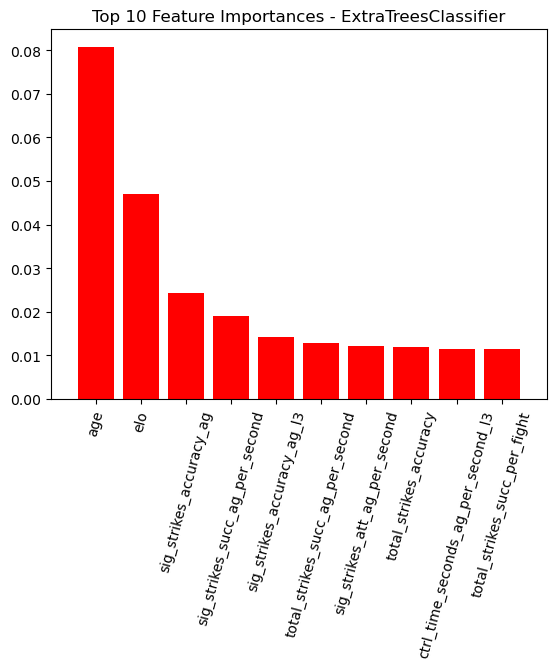

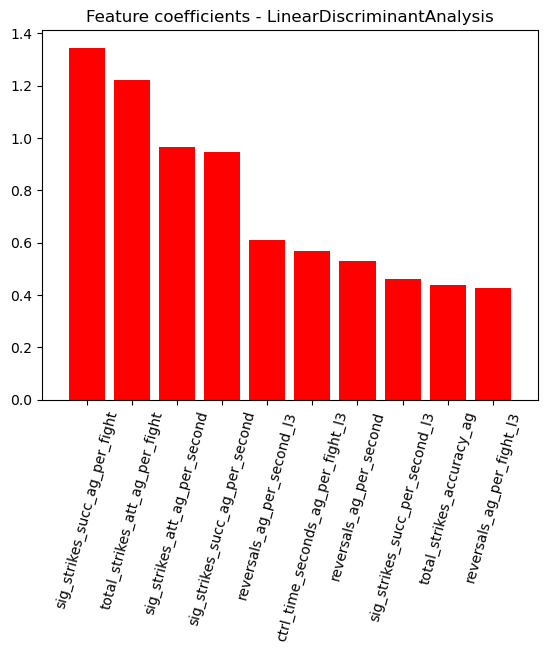

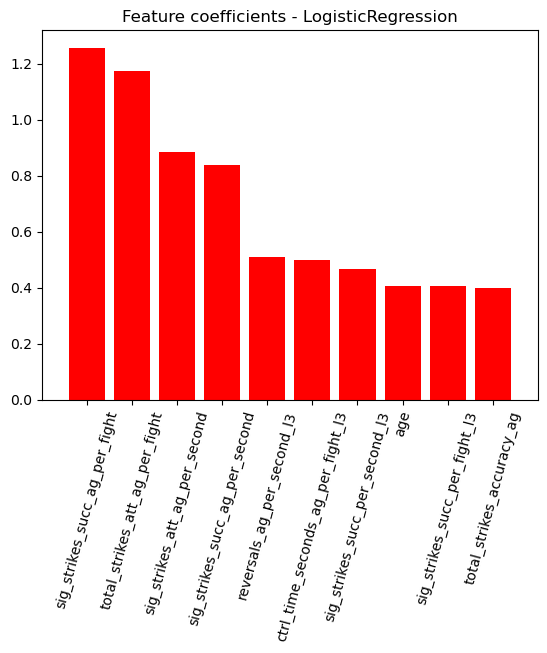

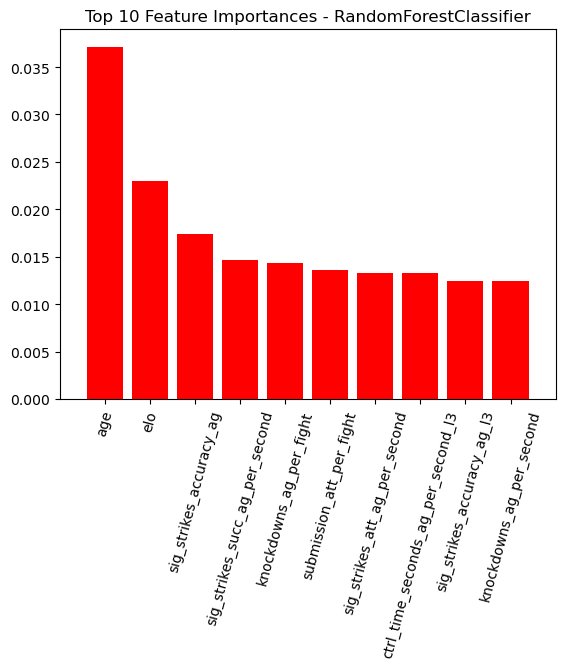

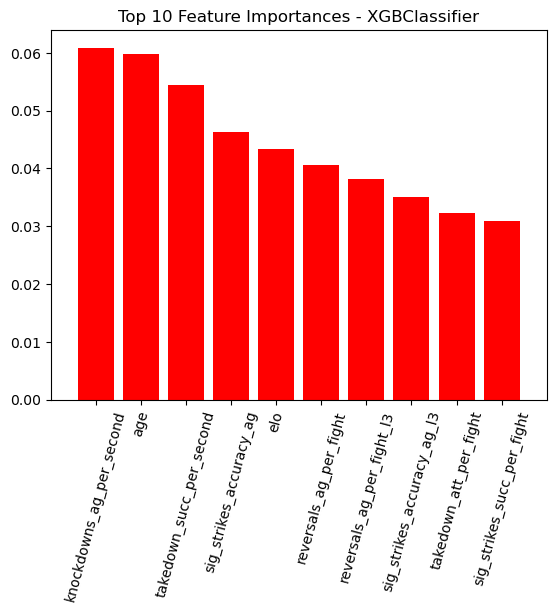

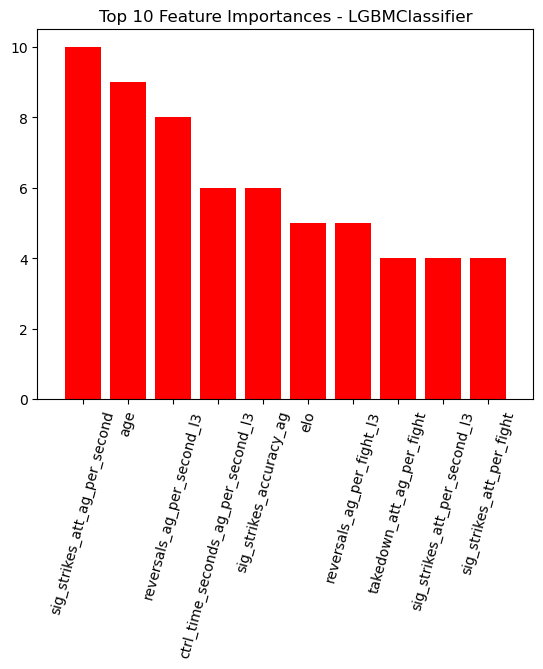

In [59]:
import matplotlib.pyplot as plt
model_feature_pairs = [(best_et_model, best_et_features), (best_lda_model, best_lda_features), (best_hgb_model, best_hgb_features), (best_log_model, best_log_features), (best_rf_model, best_rf_features), (best_xgb_model, best_xgb_features), (best_lgbm_model, best_lgbm_features)]

for model, feature in model_feature_pairs:
    X = features_prepped[list(feature)]  
    feature_names = X.columns
    model.fit(X, target)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        filtered_indices = [i for i in indices if 'win' not in feature_names[i].lower() and 'loss' not in feature_names[i].lower()]
        top_indices = filtered_indices[:10]
        plt.figure()
        plt.title(f"Top 10 Feature Importances - {model.__class__.__name__}")
        plt.bar(range(len(top_indices)), importances[top_indices], color="r", align="center")
        plt.xticks(range(len(top_indices)), [feature_names[i] for i in top_indices], rotation=75)
        plt.xlim([-1, len(top_indices)])
        plt.show()
    elif hasattr(model, "coef_"):
        coefficients = model.coef_[0]
        indices = np.argsort(np.abs(coefficients))[::-1]
        filtered_indices = [i for i in indices if 'win' not in feature_names[i].lower() and 'loss' not in feature_names[i].lower()]
        top_indices = filtered_indices[:10]
        plt.figure()
        plt.title(f"Feature coefficients - {model.__class__.__name__}")
        plt.bar(range(10), np.abs(coefficients)[top_indices], color="r", align="center")
        plt.xticks(range(10), [feature_names[i] for i in top_indices], rotation=75)
        plt.xlim([-1, 10])
        plt.show()
    


## Ensemble Fitting

In [53]:
from sklearn.metrics import log_loss, accuracy_score




folds = []
vals = []
for train_index, val_index in kfold.split(features_prepped):
    X_train = features_prepped.iloc[train_index] 
    X_val = features_prepped.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]
    predictions = []
    
    for i, (model, feature) in enumerate(model_feature_pairs):
        model.fit(X_train[list(feature)], y_train)
        predictions.append(model.predict_proba(X_val[list(feature)]))
    folds.append(predictions) 
    vals.append(y_val)
   


In [55]:
from scipy.optimize import minimize

def ensemble_log_loss(weights, folds, vals):
    exp_sum = np.sum([np.exp(w) for w in weights])
    scores = []
    for j, fold in enumerate(folds):
        prediction = np.zeros((len(vals[j]), 2))
        for i, pred in enumerate(fold):
            prediction += pred * np.exp(weights[i]) / exp_sum 
        score = log_loss(vals[j], prediction)
        scores.append(score)
 
    return np.mean(scores)

# Initial weights
initial_weights = [0.0] * 7

# Call minimize
result = minimize(ensemble_log_loss, initial_weights, args=(folds, vals), method='cobyla')

# Optimal weights
optimal_weights = result.x

print("Optimal weights:", optimal_weights)
print("Minimum log loss:", result.fun)


Optimal weights: [-2.0707532   5.67466008 -2.29085174  1.36016184 -2.19081286 -1.21410847
  5.15779351]
Minimum log loss: 0.6281051122315559


In [56]:
for (model, feature), weight in zip(model_feature_pairs, optimal_weights):
    print(model.__class__.__name__, np.exp(weight)/np.sum([np.exp(w) for w in optimal_weights]))

ExtraTreesClassifier 0.0002684480185314499
LinearDiscriminantAnalysis 0.6203695177616845
HistGradientBoostingClassifier 0.0002154133542632818
LogisticRegression 0.00829636162798212
RandomForestClassifier 0.00023807783168055982
XGBClassifier 0.0006322608373483812
LGBMClassifier 0.36997992056850987


In [57]:
from sklearn.metrics import log_loss, accuracy_score
# Make predictions on the test set
target_test = df_test['result_code']
features_test = df_test[df_test.columns[:-1]]

# Transform the test data
features_prepped_test = pd.DataFrame(scaler.transform(features_test), columns=input.columns)
best_lda_model.fit(features_prepped[list(best_lda_features)], target)
et_pred = best_et_model.predict_proba(features_prepped_test[list(best_et_features)]) * (np.exp(optimal_weights[0])/np.sum([np.exp(w) for w in optimal_weights]))
lda_pred = best_lda_model.predict_proba(features_prepped_test[list(best_lda_features)]) #* (np.exp(optimal_weights[1])/np.sum([np.exp(w) for w in optimal_weights]))
hgb_pred = best_hgb_model.predict_proba(features_prepped_test[list(best_hgb_features)]) * (np.exp(optimal_weights[2])/np.sum([np.exp(w) for w in optimal_weights]))
log_pred = best_log_model.predict_proba(features_prepped_test[list(best_log_features)]) * (np.exp(optimal_weights[3])/np.sum([np.exp(w) for w in optimal_weights]))
rf_pred = best_rf_model.predict_proba(features_prepped_test[list(best_rf_features)]) * (np.exp(optimal_weights[4])/np.sum([np.exp(w) for w in optimal_weights]))
xgb_pred = best_xgb_model.predict_proba(features_prepped_test[list(best_xgb_features)]) * (np.exp(optimal_weights[5])/np.sum([np.exp(w) for w in optimal_weights]))
lgbm_pred = best_lgbm_model.predict_proba(features_prepped_test[list(best_lgbm_features)]) * (np.exp(optimal_weights[6])/np.sum([np.exp(w) for w in optimal_weights]))

# Sum up the weighted predictions 
ensemble_pred = et_pred + lda_pred + hgb_pred + log_pred + rf_pred + xgb_pred + lgbm_pred
ensemble_pred_labels = np.argmax(ensemble_pred, axis=1)
print('Ensemble Test Log Loss', log_loss(target_test, ensemble_pred))
print('Ensemble Test Accuracy', accuracy_score(target_test, ensemble_pred_labels))

Ensemble Test Log Loss 0.6560603559742745
Ensemble Test Accuracy 0.6096256684491979


In [ ]:

numerical_columns = ['knockdowns', 'total_strikes_att', 'total_strikes_succ', 'sig_strikes_att',
       'sig_strikes_succ', 'takedown_att', 'takedown_succ', 'submission_att',
       'reversals', 'ctrl_time_seconds', 'finish_time_seconds', 'count']
result_columns = ['win', 'ko_win', 'ko_loss', 'sub_win', 'sub_loss', 'dec_win', 'dec_loss']
accuracy_columns = ['total_strikes', 'sig_strikes']
for column in numerical_columns[:-2]:
    data = []
    name = column+'_ag'
    stats = list(df[column])
    for i, stat in enumerate(stats):
        if i % 2 == 0:
            data.append(stats[i+1])
            data.append(stat)
    df[name] = data
    

# Compute running total for each numerical column per fighter
for column in numerical_columns:
    df[f'{column}_RunningTotal'] = df.groupby('name')[column].cumsum() 
    if column != 'finish_time_seconds' and column != 'count' and 'win' not in column and 'loss' not in column:
        df[f'{column}_ag_RunningTotal'] = df.groupby('name')[column+'_ag'].cumsum() 
for column in result_columns:
    df[f'{column}_RunningTotal'] = df.groupby('name')[column].cumsum() 
mask = [True]*len(df)
for i, count in enumerate(list(df.count_RunningTotal)):
    if i % 2 == 0:
        if count < 3 or list(df.count_RunningTotal)[i+1] < 3:
            mask[i] = False
            mask[i+1] = False
for column in numerical_columns[:-2]:
    df[column+'_per_second'] = df[column+'_RunningTotal'] / df['finish_time_seconds_RunningTotal'] 
    df[column+'_per_fight'] = df[column+'_RunningTotal'] / df['count_RunningTotal'] 
    df[column+'_ag'+'_per_second'] = df[column+'_ag'+'_RunningTotal'] / df['finish_time_seconds_RunningTotal']
    df[column+'_ag'+'_per_fight'] = df[column+'_ag'+'_RunningTotal'] / df['count_RunningTotal']

df['time_per_fight'] = df['finish_time_seconds_RunningTotal'] / df['count_RunningTotal']
for column in accuracy_columns:
    df[column+'_accuracy'] = df[column+'_succ_RunningTotal'] / df[column+'_att_RunningTotal'] 
    df[column+'_accuracy_ag'] = df[column+'_succ_ag_RunningTotal'] / df[column+'_att_ag_RunningTotal'] 

# Compute running total for each numerical column per fighter
for column in numerical_columns:
    df[f'{column}_RunningTotal_l3'] = df.groupby('name')[column].transform(lambda x: x.rolling(window=3, min_periods=1).sum())
    if column != 'finish_time_seconds' and column != 'count':
        df[f'{column}_ag_RunningTotal_l3'] = df.groupby('name')[column+'_ag'].transform(lambda x: x.rolling(window=3, min_periods=1).sum())

for column in result_columns:
    df[f'{column}_RunningTotal_l3'] = df.groupby('name')[column].transform(lambda x: x.rolling(window=3, min_periods=1).sum()) 

for column in numerical_columns[:-2]:
    df[column+'_per_second_l3'] = df[column+'_RunningTotal_l3'] / df['finish_time_seconds_RunningTotal_l3'] 
    df[column+'_per_fight_l3'] = df[column+'_RunningTotal_l3'] / df['count_RunningTotal_l3']    
    df[column+'_ag'+'_per_second_l3'] = df[column+'_ag'+'_RunningTotal_l3'] / df['finish_time_seconds_RunningTotal_l3']
    df[column+'_ag'+'_per_fight_l3'] = df[column+'_ag'+'_RunningTotal_l3'] / df['count_RunningTotal_l3']

df['time_per_fight_l3'] = df['finish_time_seconds_RunningTotal_l3'] / df['count_RunningTotal_l3']
for column in accuracy_columns:
    df[column+'_accuracy_l3'] = df[column+'_succ_RunningTotal_l3'] / df[column+'_att_RunningTotal_l3'] 
    df[column+'_accuracy_ag_l3'] = df[column+'_succ_ag_RunningTotal_l3'] / df[column+'_att_ag_RunningTotal_l3'] 

for column in result_columns:
    df[column+'_percentage'] = df[f'{column}_RunningTotal'] / df['count_RunningTotal']
    df[column+'_percentage_l3'] = df[f'{column}_RunningTotal_l3'] / df['count_RunningTotal_l3']

df_filtered = df[mask]
df_filtered

In [ ]:
from collections import defaultdict

def dd():
    return {}

rating = defaultdict(dd)
for i, row in df_filtered.iterrows():
    for column in features_prepped.columns:
        try:
            if column == 'elo':
                rating[column][row['name']] = elo[row['fighter_id']]
            else:
                rating[column][row['name']] = row[column]
        except:
            pass
rating   

In [ ]:
per_sec_mask = []
for i, column in enumerate(features_prepped.columns):
    if 'second' in column and 'l3' not in column:
        per_sec_mask.append(True)
    else:
        per_sec_mask.append(False)
per_sec_mask = np.array(per_sec_mask).reshape(-1,1).T
per_sec_mask

In [ ]:

def preview(f1, f2):
    metrics = np.array([rating[col][f2] - rating[col][f1] for col in rating]).reshape(-1, 1).T
    metrics_scaled = scaler.transform(metrics)
    metrics_scaled_df = pd.DataFrame(metrics_scaled, columns=features_prepped.columns)
    comps = []
    for i, row in prev_fights.iterrows():
        row_arr = np.array(row).reshape(-1,1).T
        score1 = np.abs(metrics_scaled-row_arr)[per_sec_mask].sum()
        score2 = np.abs(metrics_scaled+row_arr)[per_sec_mask].sum()
        comps.append(min(score1, score2))
    comp_table = pd.DataFrame(index=names.index)
    comp_table['comps'] = comps
    similar_fights = names.loc[comp_table.sort_values('comps').index[:10]]
    # Make prediction
    #et_pred = best_et_model.predict_proba(metrics_scaled_df[list(best_et_features)]) * (np.exp(optimal_weights[0])/np.sum([np.exp(w) for w in optimal_weights]))
    lda_pred = best_lda_model.predict_proba(metrics_scaled_df[list(best_lda_features)])# * (np.exp(optimal_weights[1])/np.sum([np.exp(w) for w in optimal_weights]))
    #hgb_pred = best_hgb_model.predict_proba(metrics_scaled_df[list(best_hgb_features)]) * (np.exp(optimal_weights[2])/np.sum([np.exp(w) for w in optimal_weights]))
    #log_pred = best_log_model.predict_proba(metrics_scaled_df[list(best_log_features)]) * (np.exp(optimal_weights[3])/np.sum([np.exp(w) for w in optimal_weights]))
    #rf_pred = best_rf_model.predict_proba(metrics_scaled_df[list(best_rf_features)]) * (np.exp(optimal_weights[4])/np.sum([np.exp(w) for w in optimal_weights]))
    #xgb_pred = best_xgb_model.predict_proba(metrics_scaled_df[list(best_xgb_features)]) * (np.exp(optimal_weights[5])/np.sum([np.exp(w) for w in optimal_weights]))
    #lgbm_pred = best_lgbm_model.predict_proba(metrics_scaled_df[list(best_lgbm_features)]) * (np.exp(optimal_weights[6])/np.sum([np.exp(w) for w in optimal_weights]))
    
    # Sum up the weighted predictions
    #ensemble_pred = et_pred + lda_pred + hgb_pred + log_pred + rf_pred + xgb_pred + lgbm_pred
    ensemble_pred = lda_pred
    prediction = pd.DataFrame(ensemble_pred, columns=[f1, f2])
    return prediction

metrics_scaled = preview('Israel Adesanya', 'Israel Adesanya')
metrics_scaled

In [ ]:
similar_fights

In [ ]:
for 
elo[679]

In [ ]:
target.mean()

In [ ]:
rating